# EDA, Data Visualization, and Feature Engineering

In [1]:
# !bash push.sh

## IMPORTS

In [45]:
import requests
import pandas                        as pd
import numpy                         as np
import math

import seaborn                       as sns
import matplotlib.pyplot             as plt
from wordcloud                       import WordCloud, STOPWORDS 
import pyLDAvis
import pyLDAvis.gensim
from pprint                          import pprint

from googletrans                     import Translator
translator = Translator()
from spellchecker                    import SpellChecker
spellcheck = SpellChecker()

import spacy
nlp = spacy.load('en_core_web_sm')

import nltk
from nltk.tokenize                   import TweetTokenizer
from nltk.corpus                     import stopwords
from nltk                            import bigrams

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cvec = CountVectorizer()
from sklearn.manifold                import TSNE
from sklearn.metrics                 import accuracy_score
from sklearn                         import preprocessing

import gensim
from gensim                          import models
from gensim.models                   import CoherenceModel
from gensim.models                   import Word2Vec
from gensim.models                   import Phrases
from gensim.models.phrases           import Phraser

import mittens
from mittens                         import GloVe

from collections                     import Counter
import itertools
import re
tokenizer = TweetTokenizer(preserve_case = True, strip_handles = True)

import random
import time
from tqdm                            import tqdm
import joblib
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline

In [3]:
eng_train = pd.read_csv('Data/trac2_eng_train.csv')
eng_test = pd.read_csv('Data/trac2_eng_dev.csv')
eng = eng_train.append(eng_test, ignore_index=True)
eng.sample(5)

,ID,Text,Sub-task A,Sub-task B
38,C33.785,Watch this amazing video\n[https://www.youtube...,NAG,NGEN
3679,C4.749,The more scary fact is that people actually li...,CAG,NGEN
3939,C7.2553,👍 well said sir. Guys also watch Lakshay Chowd...,NAG,NGEN
2878,C10.149,Arnab is exposing these fools like onions.,NAG,NGEN
4234,C9.317,RSD top Journalist.Hats off.,NAG,NGEN


In [37]:
hin = pd.read_csv('Data/cleaned hindi.csv', index=False)
ben = pd.read_csv('Data/cleaned bangla.csv', index=False)

TypeError: parser_f() got an unexpected keyword argument 'index'

In [4]:
classes = ['NAG', 'CAG', 'OAG'] # Dependant variable

### Null / Duplicate Entries

In [5]:
eng.info() # no null enteries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          5329 non-null   object
 1   Text        5329 non-null   object
 2   Sub-task A  5329 non-null   object
 3   Sub-task B  5329 non-null   object
dtypes: object(4)
memory usage: 166.7+ KB


In [6]:
set(eng.duplicated().tolist()) # no duplicates

{False}

### Class Balance

In [7]:
def barplot(df, x, y, title, label, ylabel, dim, orient = "v", ci = False, hue = None):
    
    plt.figure(figsize = dim, facecolor = "white")
    sns.barplot(x = x, y = y, data = df, orient = orient, ci = ci, hue = hue)
    plt.title(f"{title}", size = 18)
    plt.xlabel(f"{label}", size = 16)
    plt.ylabel(f"{ylabel}", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.tight_layout();

NAG    3375
CAG     453
OAG     435
Name: Sub-task A, dtype: int64

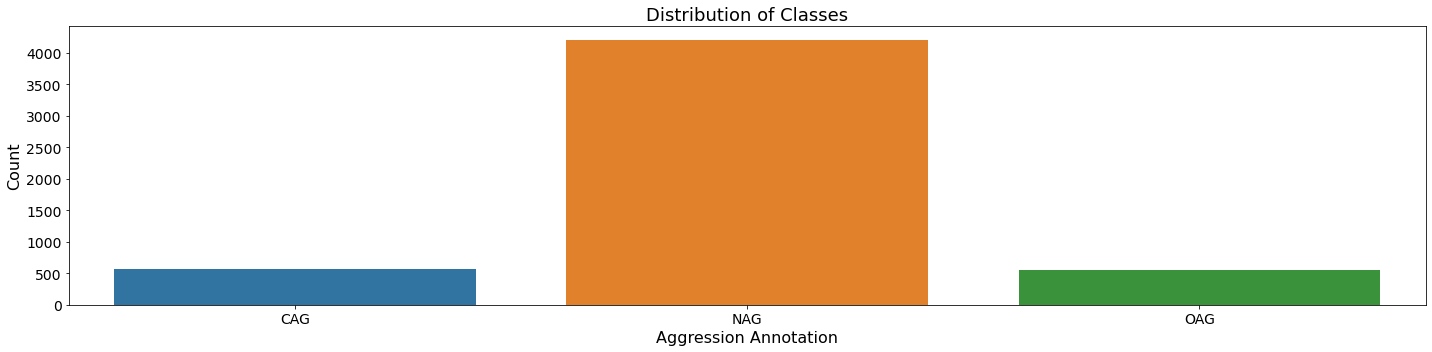

In [8]:
taskA_df = (eng.set_index(['ID', 'Sub-task A']).count(level='Sub-task A'))

barplot(df = taskA_df,
        x = taskA_df.index,
        y = "Text",
        title = "Distribution of Classes",
        label = "Aggression Annotation",
        ylabel = "Count",
        dim = (20, 5))

eng_train['Sub-task A'].value_counts()

NGEN    3954
GEN      309
Name: Sub-task B, dtype: int64

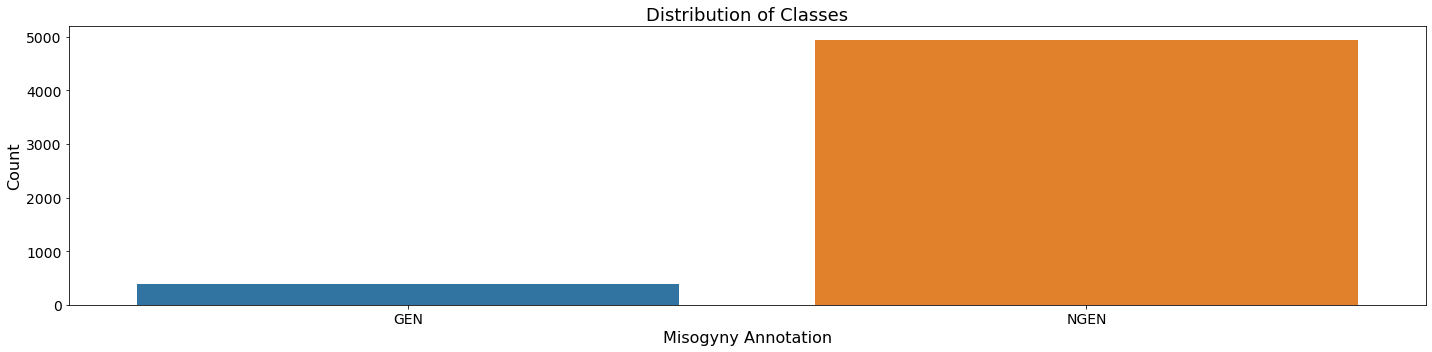

In [9]:
taskB_df = (eng.set_index(['ID', 'Sub-task B']).count(level='Sub-task B'))

barplot(df = taskB_df,
        x = taskB_df.index,
        y = "Text",
        title = "Distribution of Classes",
        label = "Misogyny Annotation",
        ylabel = "Count",
        dim = (20, 5))

eng_train['Sub-task B'].value_counts()

## DATA CLEANING & NORMALIZATION

### Part-of-Speech Distribution

In [10]:
def POS(df, attribute):
    total_tokens = []
    freq = {}
    for text in df[attribute]:
        doc = nlp(text)
        tokens = []
        for word in doc:
            pos = word.pos_
            if (pos in freq): 
                freq[pos] += 1
            else: 
                freq[pos] = 1
            tokens.append(pos)

        total_tokens.append(tokens)
    pos_df = pd.DataFrame({'POS': list(freq.keys()), 'Frequency':list(freq.values())})
    return pos_df

      POS  Frequency
0     ADJ       7350
1    NOUN      18875
2       X        957
3   SPACE       5286
4   PROPN      10954
5   PUNCT      10837
6    VERB      12425
7    PRON       8000
8     ADP       7137
9   SCONJ       1954
10    DET       9055
11    AUX       6297
12  CCONJ       3037
13   PART       2852
14    ADV       5420
15   INTJ        921
16    NUM       1025
17    SYM        309

Part-of-speech tagging counts for combined corpus


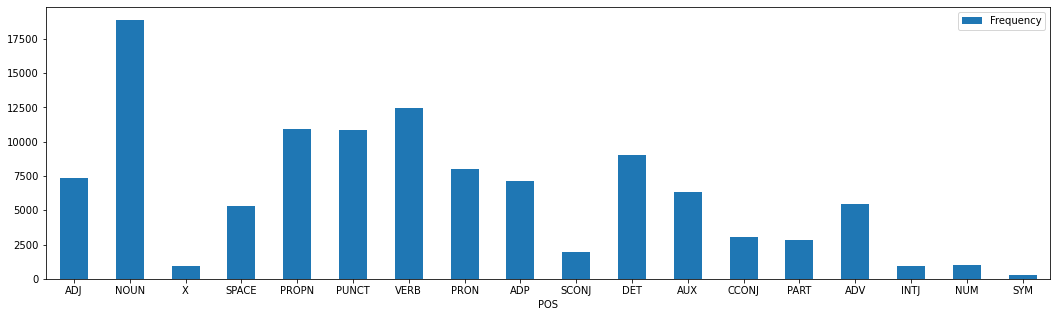

In [11]:
pos_df = POS(eng, 'Text')
print(pos_df)
print('\nPart-of-speech tagging counts for combined corpus')
pos_df.plot.bar(x ='POS', y ='Frequency', rot = 0, figsize=(18,5))

### List of transliterated proper nouns (PROPN) in the corpus

In [12]:
def transliteration_list(df):
    propn = []
    for text in df['Text']:
        doc = nlp(text)
        for word in doc:
            pos = word.pos_
            if (pos == 'PROPN'): 
                propn.append(word.text)
            else: 
                continue
    return propn

In [13]:
propn = transliteration_list(eng)

### Stopwords

In [14]:
def fetch_stopwords(url):
    stop = pd.read_csv(url, sep='\n', header=0, names=['words'])
    stop = stop['words'].values.tolist()
    return stop

In [17]:
# from stopwordsiso import stopwords
# bangla_stopwords = stopwords('bn')

hinglish_stopwords = fetch_stopwords('https://raw.githubusercontent.com/TrigonaMinima/HinglishNLP/master/data/assets/stop_hinglish')
english_stopwords = set(stopwords.words('english') + hinglish_stopwords)
hindi_stopwords = set(fetch_stopwords('https://raw.githubusercontent.com/TrigonaMinima/HinglishNLP/master/data/assets/stop_hindi'))
bangla_stopwords = set(fetch_stopwords('https://raw.githubusercontent.com/rachitsaksena/Multilingual-Agression-Classification/master/Cache/Models/bangla%20stop.txt'))

In [18]:
stop_dict = {'en': english_stopwords,
             'hi': hindi_stopwords,
             'bn': bangla_stopwords}

### Emoji and Special Character Removal

In [19]:
def deEmojify(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F923"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [20]:
def clean_text(df, lang):
    stop_words = stop_dict[lang]
    df['clean text'] = df['Text']
    for i in range(df.shape[0]):
        sentence = df['Text'].iloc[i]
        sentence = deEmojify(sentence)
        sentence = re.sub(r"([.!?])", r"", sentence)
        sentence = re.sub(r'[/(){}\[\]\|@,;:.]', r'', str(sentence))
#         sentence = re.sub(r"[^a-z]+", r" ", sentence)
        sentence = ' '.join(word.lower() for word in sentence.split() if word not in stop_words and len(word)>2)
        df['clean text'].iloc[i] = sentence
#     df['tokenized'] = [tokenizer.tokenize(text) for text in df['clean text']] #problem
    df['tokenized'] = [text.split() for text in df['clean text']]
    return df

In [21]:
clean_text(eng, 'en')
eng.head()

,ID,Text,Sub-task A,Sub-task B,clean text,tokenized
0,C45.451,Next part,NAG,NGEN,next part,"[next, part]"
1,C47.11,Iii8mllllllm\nMdxfvb8o90lplppi0005,NAG,NGEN,iii8mllllllm mdxfvb8o90lplppi0005,"[iii8mllllllm, mdxfvb8o90lplppi0005]"
2,C33.79,🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...,NAG,NGEN,osm vedio upmake vedios,"[osm, vedio, upmake, vedios]"
3,C4.1961,What the fuck was this? I respect shwetabh and...,NAG,NGEN,what fuck respect shwetabh watching videos lon...,"[what, fuck, respect, shwetabh, watching, vide..."
4,C10.153,Concerned authorities should bring arundathi R...,NAG,NGEN,concerned authorities bring arundathi roy type...,"[concerned, authorities, bring, arundathi, roy..."


      POS  Frequency
0     ADJ       5322
1    NOUN      14521
2   PROPN      11641
3     DET        840
4    VERB       7136
5    PRON        942
6    INTJ        354
7   CCONJ        320
8     ADV       1658
9    PART        433
10    NUM        431
11  PUNCT        774
12    AUX        458
13  SCONJ        123
14    ADP        198
15      X        204
16    SYM        143

Part-of-speech tagging counts for combined corpus


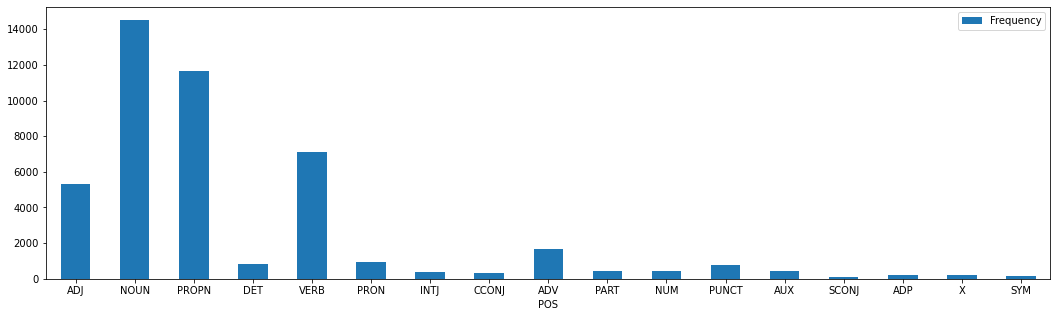

In [22]:
pos_df = POS(eng, 'clean text')
print(pos_df)
print('\nPart-of-speech tagging counts for combined corpus')
pos_df.plot.bar(x ='POS', y ='Frequency', rot = 0, figsize=(18,5))

### Lexicon Normalization

In [23]:
def script_tag(text):
    ben = re.compile("[" u"\U00000980-\U000009FF" "]+", flags=re.UNICODE) # Bengali
    hin = re.compile("[" u"\U00000900-\U0000097F" "]+", flags=re.UNICODE) # Hindi

    if ben.match(text):
        return 'bn'
    elif hin.match(text):
        return 'hi'
    else:
        return 'en'

In [24]:
def language_tag(df, dest="en"):
    df['normalized lexicon'] = df['clean text']
    ben = re.compile("[" u"\U00000980-\U000009FF" "]+", flags=re.UNICODE) # Bengali
    hin = re.compile("[" u"\U00000900-\U0000097F" "]+", flags=re.UNICODE) # Hindi
    for i in range(df.shape[0]):
        lis = []
        words = df['tokenized'].iloc[i]
        trans_script = translator.translate(" ".join(words)).src
        for word in words:
            script = script_tag(word)
#             print(word, trans_script)
            if(script == 'hi' or trans_script == 'hi'):
                t_word = translator.translate(word, src='hi', dest=dest).text.lower()
                if(script_tag(t_word)==dest): lis.append(t_word)
            elif(script == 'bn' or trans_script == 'bn'):
                t_word = translator.translate(word, src='bn', dest=dest).text.lower()
                if(script_tag(t_word)==dest): lis.append(t_word)
#                 print(word, t_word, lis)
            elif(script == 'en' or trans_script == 'en'):
                if word in propn: #PROPN
                    lis.append(word.lower())
                    continue
                elif len(spellcheck.unknown([word]))!=0: #SPELL CHECK
                    t_word = spellcheck.correction(word).lower()
                else:
                    t_word = word.lower()
                t_word = translator.translate(word, src='en', dest=dest).text.lower()
                if(script_tag(t_word)==dest): lis.append(t_word)
        df['normalized lexicon'].iloc[i] = lis
    return df

In [38]:
# ENGLISH
# language_tag(eng)  # Takes considerable amount of time to run

In [29]:
eng['monolingual'] = eng['normalized lexicon'].apply(lambda x : " ".join(x))

In [30]:
eng.to_csv('Data/cleaned english.csv', index=False)

In [33]:
eng_clean = pd.read_csv('Data/cleaned english.csv')

In [34]:
eng_clean.sample(5)

,ID,Text,Sub-task A,Sub-task B,clean text,tokenized,normalized lexicon,monolingual
5082,C33.778.1,Ajay Kumar Gupta thank you 😇,NAG,NGEN,ajay kumar gupta,"['ajay', 'kumar', 'gupta']","['ajay', 'kumar', 'gupta']",ajay kumar gupta
4610,C4.2084.3,"Potraying a character honestly, depicting his ...",NAG,NGEN,potraying character honestly depicting facial ...,"['potraying', 'character', 'honestly', 'depict...","['portraying', 'character', 'honestly', 'depic...",portraying character honestly depicting facial...
3509,C63.16,Nise Video,NAG,NGEN,nise video,"['nise', 'video']","['nise', 'video']",nise video
762,C4.1197,That's why I watch ANIME instead of bollywood,NAG,NGEN,that's watch anime instead bollywood,"[""that's"", 'watch', 'anime', 'instead', 'bolly...","[""that's"", 'watch', 'anime', 'instead', 'bolly...",that's watch anime instead bollywood
1631,C33.300,Awsm girls😘😘😘😘,NAG,NGEN,awsm girls,"['awsm', 'girls']","['awsm', 'girls']",awsm girls


### Class Interdependence

#### WORD CLOUD

In [35]:
# WORD CLOUD
def word_cloud(df):
    for agg in classes:
        words = ''
        stopwords = set(STOPWORDS)

        for val in df[df["Sub-task A"] == agg]['monolingual']: 
            tokens = str(val).split() 
            words += " ".join(tokens)+" "

        wordcloud = WordCloud(width = 800, 
                              height = 800, 
                              background_color ='white', 
                              stopwords = stopwords, 
                              min_font_size = 10).generate(words) 

        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 

        print(agg)
        plt.show() 
        print("\n\n\n")

#### 1. English

NAG


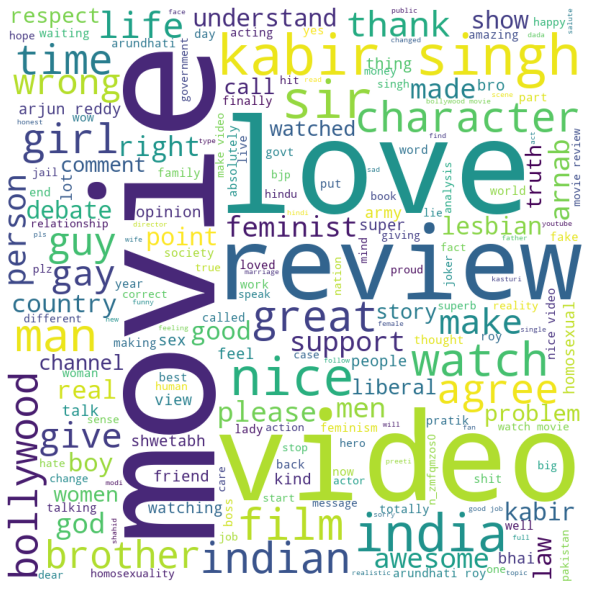





CAG


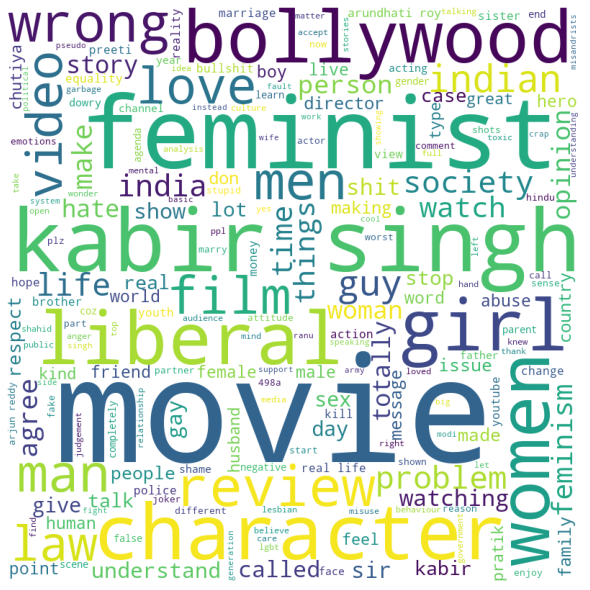





OAG


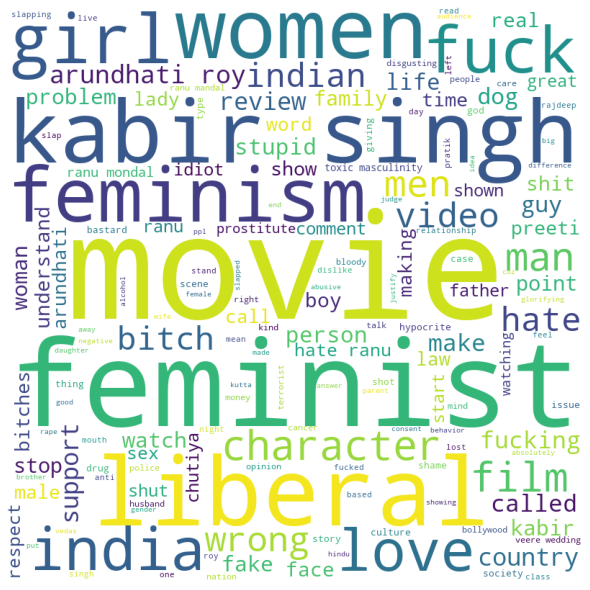

In [36]:
word_cloud(eng)

#### 2. Hindi

In [ ]:
word_cloud(hin)

#### 3. Bangla

In [ ]:
word_cloud(ben)

#### MOST FREQUENT WORDS

In [ ]:
# MOST FREQUENT STATS

def plot_most_frequent_words(df, agg):
    cnt = 0
    fig = plt.figure(figsize = (24, 20), facecolor = "white")   
    cnt += 1
    ax = fig.add_subplot(2, 2, cnt)

    sns.barplot(x = 0, y = df.index, data = df, palette = "deep")

    plt.title(f"Most Common Words from {agg} class are", size = 20)
    plt.xlabel("Frequency", size = 18)
    plt.ylabel("Word", size = 18)
    plt.xticks(size = 16)
    plt.yticks(size = 17)

In [ ]:
def N_most_freq_words(df, n):
    sns.set(style = "white", palette = "deep")

    for agg in classes:
        subset = df[df["Sub-task A"] == agg]
        vecs = cvec.fit_transform(subset["monolingual"].values.astype('U'))
        vectorized_df = pd.DataFrame(vecs.toarray(), columns = cvec.get_feature_names())

        # Getting the 20 most frequent words from each
        frequent = pd.DataFrame(vectorized_df.sum().sort_values(ascending = False).head(n))

        plot_most_frequent_words(df = frequent, agg = agg)

#### 1. English

In [ ]:
N_most_freq_words(eng, 20)

#### 2. Hindi

In [ ]:
N_most_freq_words(hin, 20)

#### 3. Bangla

In [31]:
N_most_freq_words(ben, 20)

In [ ]:
# CLEANING

# FEATURE GENERATION & ENGINEERING

In [183]:
# ENGLISH
x = eng['monolingual'].apply(lambda w : str(w)) 
y = eng['Sub-task A']            

# HINDI
# x = hin['monolingual'].apply(lambda w : str(w)) 
# y = hin['Sub-task A']                           

# BANGLA
# x = ben['monolingual'].apply(lambda w : str(w)) 
# y = ben['Sub-task A']                           

In [39]:
def run_tsne(df, y, vec_columns_count):
    concat_df = pd.concat([df, y.reset_index(drop=True)], axis = 1)
    time_start = time.time()
    algo = TSNE(n_components = 2, random_state = 0, n_iter = 2000)
    tsne_data = algo.fit_transform(concat_df.iloc[:,:vec_columns_count])
    time_end = time.time()
    print('t-SNE Completed. Total time it took: {} seconds'.format(time_end-time_start))
    
    # t-SNE plot
    tsne_data = np.vstack((tsne_data.T, concat_df['Sub-task A'])).T
    tsne_df = pd.DataFrame(data = tsne_data , columns=("Dim1", "Dim2", "label"))
    sns.FacetGrid(data = tsne_df, hue = 'label', size = 15).map(plt.scatter, "Dim1", "Dim2").add_legend()
    plt.show()

In [46]:
label_encoder = preprocessing.LabelEncoder()

# Using misogyny as a feature
eng['Sub-task B'] = label_encoder.fit_transform(eng['Sub-task B'])
hin['Sub-task B'] = label_encoder.fit_transform(hin['Sub-task B'])
ben['Sub-task B'] = label_encoder.fit_transform(ben['Sub-task B'])

## Bag Of Words

In [188]:
cv = CountVectorizer(ngram_range=(1, 5), min_df=.02) # adjust min_df and max_df from count vectorizer documentation, scikit-learn

In [189]:
def bow(df, lang):
    x = df['monolingual'].apply(lambda w : str(w))
    vecs = cv.fit_transform(x)
    bow_df = pd.DataFrame(vecs.todense(), columns = cv.get_feature_names())
    bow_df['Sub-task B'] = df['Sub-task B']
    joblib.dump(cv, 'bow_{}.pkl'.format(lang)) # pickled vecs

    print("BoW shape: ", bow_df.shape)

    return bow_df

In [190]:
bow_df = bow(eng, 'en')
# bow_df = bow(hin, 'hi')
# bow_df = bow(ben, 'bn')

BoW shape:  (4263, 54)


In [194]:
bow_df.sample(5)

,agree,and,arundhati,bollywood,bollywood hollywood,but,couture,feminist,feminists,film,...,time time,video,video video,watch,watch watch,wrong,wrong wrong,you,youtube,youtube couture
3382,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2650,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


t-SNE Completed. Total time it took: 102.8717291355133 seconds


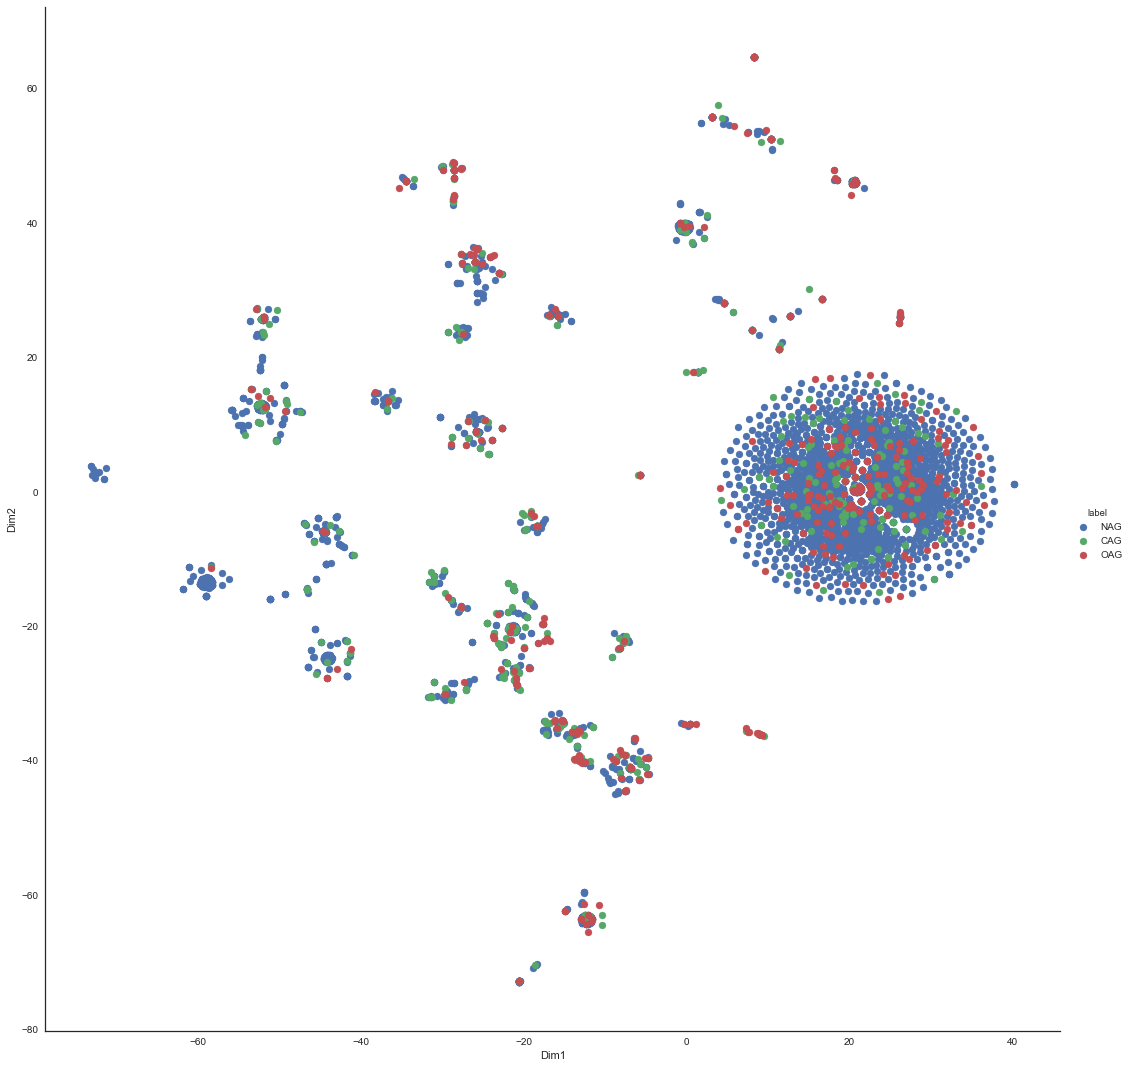

In [193]:
run_tsne(bow_df, y, bow_df.shape[1])

## TF-IDF

In [195]:
tfidf = TfidfVectorizer(ngram_range=(1, 5), min_df=.01) # refer to scikit-learn, tfidf vectorizer documentation to tune min_df and max_df 

In [196]:
def tf_idf(df, lang):
    x = eng_train_clean['monolingual'].apply(lambda w : str(w))
    vecs = tfidf.fit_transform(x)
    tfidf_df = pd.DataFrame(vecs.todense(), columns = tfidf.get_feature_names())
    tfidf_df['Sub-task B'] = df['Sub-task B']
    joblib.dump(tfidf, 'tfidf_{}.pkl'.format(lang)) # pickled vecs

    print("TF-IDF shape: ", tfidf_df.shape)

    return tfidf_df

In [ ]:
tfidf_df = tf_idf(eng, 'en')
# tfidf_df = tf_idf(hin, 'hi')
# tfidf_df = tf_idf(ben, 'bn')

In [201]:
tfidf_df.sample(5)

,acting,agree,and,arab,arjun,arjun arjun,arjun arjun reddy,arjun arjun reddy reddy,arjun reddy,arjun reddy reddy,...,women,world,world world,wrong,wrong wrong,yes,you,youtube,youtube couture,youtube couture coldwatch
2797,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.666685,0.334579,0.0,0.0,0.0,0.0,0.0,0.0,0.0
216,0.0,0.0,0.0,0.0,0.26954,0.13477,0.138437,0.138437,0.138437,0.138437,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2348,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


t-SNE Completed. Total time it took: 91.66479301452637 seconds


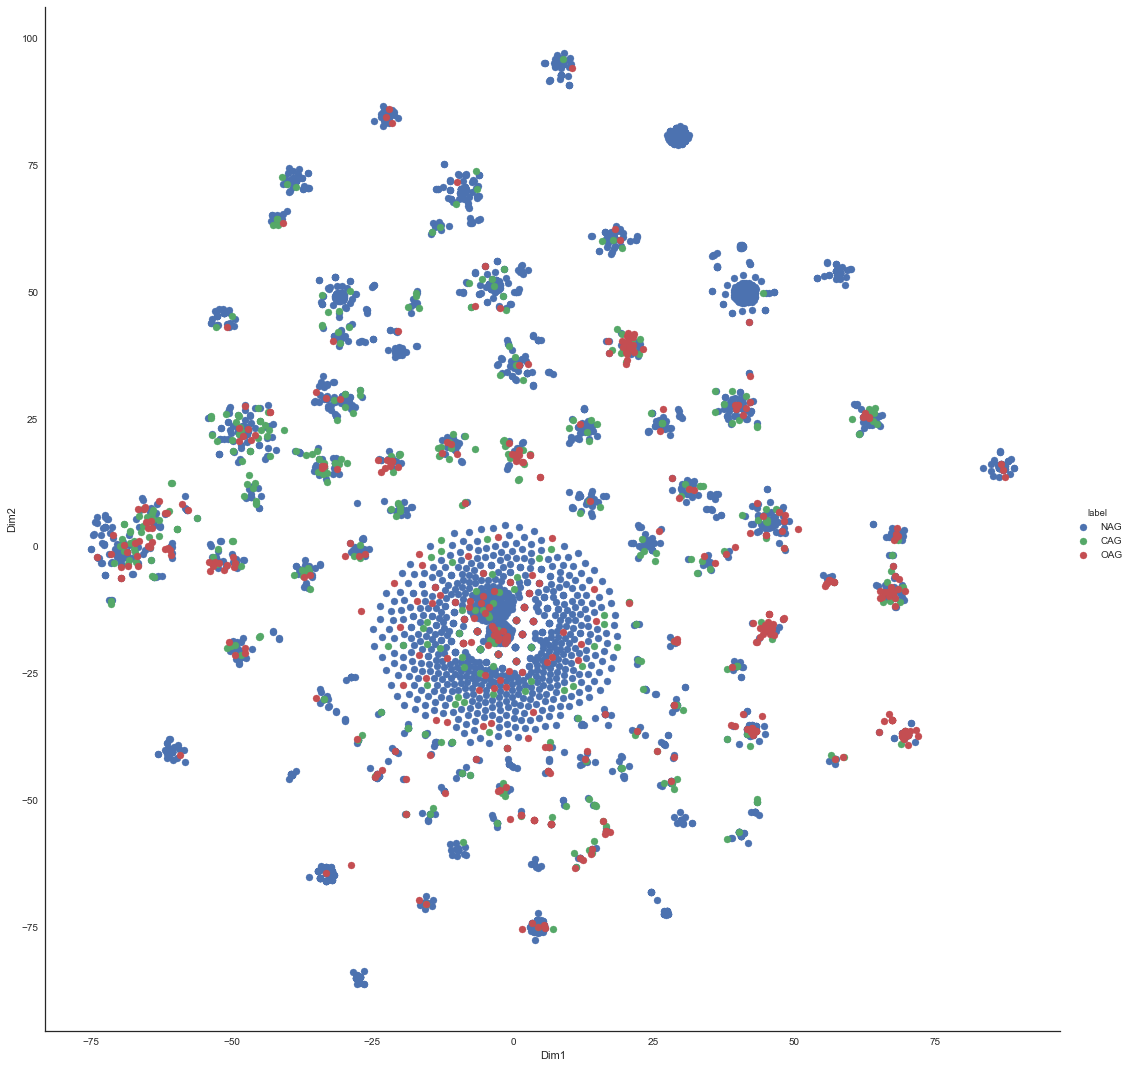

In [50]:
run_tsne(tfidf_df, y, tfidf_df.shape[1])

## Topic Modelled Vectors

### Building the optimal LDA Topic Model

In [82]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): # OPTIONAL
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    
    words = list(sent_to_words(df))
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
#     lemma = lemmatization(bigram)
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [83]:
corpus, id2word, bigrams = get_corpus(x)

In [202]:
mallet_path = '../Cache/Models/mallet-2.0.8/bin/mallet'

In [133]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    
    """
    mallet_coherence_values = []
    mallet_list = []
    
    gensim_coherence_values = []
    gensim_list = []
    
    for num_topics in range(start, limit, step):
        
        lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                      corpus=corpus, 
                                                      num_topics=num_topics, 
                                                      id2word=id2word)
        mallet_list.append(lda_mallet)
        mallet_coherencemodel = CoherenceModel(model=lda_mallet, texts=texts, dictionary=dictionary, coherence='c_v')
        mallet_coherence_values.append(mallet_coherencemodel.get_coherence())
        
        lda_gensim = gensim.models.ldamulticore.LdaMulticore(corpus = corpus,
                                                      num_topics = num_topics,
                                                      id2word = id2word,
                                                      chunksize = 100,
                                                      workers = 7, # Num. Processing Cores - 1
                                                      passes = 50,
                                                      eval_every = 1,
                                                      per_word_topics=True)
        gensim_list.append(lda_gensim)
        gensim_coherencemodel = CoherenceModel(model=lda_gensim, texts=texts, dictionary=dictionary, coherence='c_v')
        gensim_coherence_values.append(gensim_coherencemodel.get_coherence())

    return mallet_list, mallet_coherence_values, gensim_list, gensim_coherence_values

In [134]:
# Can take a long time to run.
mallet_list, mallet_coherence_values, gensim_list, gensim_coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=bigrams, start=2, limit=40, step=6)

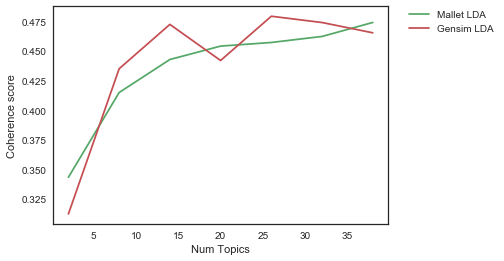

In [145]:
# Show graph
limit=40; start=2; step=6;
x_range = range(start, limit, step)
plt.subplot()
plt.plot(x_range, mallet_coherence_values, 'C1', label='Mallet LDA')
plt.plot(x_range, gensim_coherence_values, 'C2', label='Gensim LDA')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [141]:
# Coherence Scores
for m, cvm, cvg in zip(x_range, mallet_coherence_values, gensim_coherence_values):
    print("For Num Topics =", m, ", Mallet LDA has Coherence Value of", round(cvm, 4), ", Gensim LDA has Coherence Value of", round(cvg, 4))

For Num Topics = 2 , Mallet LDA has Coherence Value of 0.3434 , Gensim LDA has Coherence Value of 0.3125
For Num Topics = 8 , Mallet LDA has Coherence Value of 0.415 , Gensim LDA has Coherence Value of 0.4351
For Num Topics = 14 , Mallet LDA has Coherence Value of 0.4429 , Gensim LDA has Coherence Value of 0.4725
For Num Topics = 20 , Mallet LDA has Coherence Value of 0.4542 , Gensim LDA has Coherence Value of 0.442
For Num Topics = 26 , Mallet LDA has Coherence Value of 0.4573 , Gensim LDA has Coherence Value of 0.4794
For Num Topics = 32 , Mallet LDA has Coherence Value of 0.4623 , Gensim LDA has Coherence Value of 0.4741
For Num Topics = 38 , Mallet LDA has Coherence Value of 0.4742 , Gensim LDA has Coherence Value of 0.4654


In [180]:
# Optimal model and the topics
optimal_model = gensim_list[2] # OBSERVED OPTIMAL MODEL
optimal_num_topics = 14

# optimal_model.save('optimal_lda_model.model')

# Coherence Score: How coherent / well formed the topics are. 
# Before curve flattening, the higher the better.
print('\nCoherence Score: ', gensim_coherence_values[2])

# Preplexity: a measure of how good the model is. The lower the better.
# Valid for Gensim LDA only; Imlplementation doesn't exist for Mallet LDA.
print('\nPerplexity Score: ', optimal_model.log_perplexity(corpus))
print('\nOptimal Topics:')

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


Coherence Score:  0.47251087748734416

Perplexity Score:  -6.331866514877247

Optimal Topics:
[(0,
  '0.079*"man_man" + 0.062*"the" + 0.041*"and" + 0.032*"men" + 0.029*"god_god" '
  '+ 0.028*"life" + 0.023*"indian_indian" + 0.022*"woman" + 0.022*"this" + '
  '0.019*"women"'),
 (1,
  '0.104*"roy_roy" + 0.094*"arundhati_arundhati" + 0.077*"good_good" + '
  '0.037*"kung" + 0.037*"boss" + 0.034*"job" + 0.032*"sick" + '
  '0.027*"totally_agree" + 0.025*"kasturi_pasture" + 0.023*"mad_mad"'),
 (2,
  '0.130*"sir_sir" + 0.101*"video_video" + 0.091*"she" + '
  '0.051*"brother_brother" + 0.037*"right_right" + 0.035*"thanks" + '
  '0.031*"respect_respect" + 0.030*"channel_channel" + 0.024*"plz_plc" + '
  '0.023*"review_review"'),
 (3,
  '0.049*"law" + 0.030*"very" + 0.027*"talk" + 0.024*"rights" + 0.023*"family" '
  '+ 0.023*"sex" + 0.020*"companion" + 0.020*"sucharita" + 0.020*"ranga_range" '
  '+ 0.019*"women"'),
 (4,
  '0.060*"youtube_couture" + 0.060*"wrong_wrong" + '
  '0.042*"comresults_sea

In [171]:
# Visualize the topics (ONLY AVAILABLE IN JUPYTER NOTEBOOK)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/Users/ramanshgrover/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.134001 -0.195895       1        1  14.592455
8      0.228011 -0.155692       2        1  10.655187
0     -0.151755 -0.064381       3        1   9.606128
6     -0.125320  0.008220       4        1   7.286400
4      0.036761 -0.183409       5        1   7.118621
13    -0.023367 -0.031872       6        1   7.097891
7     -0.019507  0.095262       7        1   7.022133
3     -0.171393 -0.082923       8        1   6.303790
2      0.197499  0.212870       9        1   5.799277
10     0.210188  0.064483      10        1   5.482056
11    -0.136571  0.027099      11        1   5.367898
9      0.015292  0.219351      12        1   4.806888
5     -0.095435 -0.015353      13        1   4.728433
1     -0.098402  0.102240      14        1   4.132845, topic_info=     Category        Freq                 Term       Total  loglift  logprob
term                                                                        
14    Default  546.000000          movie_movie  546.000000  30.0000  30.0000
35    Default  217.000000                  you  217.000000  29.0000  29.0000
11    Default  319.000000          kabir_kabir  319.000000  28.0000  28.0000
23    Default  287.000000          singh_singh  287.000000  27.0000  27.0000
91    Default  161.000000              sir_sir  161.000000  26.0000  26.0000
165   Default  237.000000          video_video  237.000000  25.0000  25.0000
279   Default  147.000000            nice_nice  147.000000  24.0000  24.0000
10    Default  179.000000          india_india  179.000000  23.0000  23.0000
19    Default  257.000000        review_review  257.000000  22.0000  22.0000
128   Default  125.000000          great_great  125.000000  21.0000  21.0000
73    Default  165.000000              man_man  165.000000  20.0000  20.0000
158   Default  255.000000                 love  255.000000  19.0000  19.0000
53    Default  112.000000                  she  112.000000  18.0000  18.0000
41    Default   92.000000              roy_roy   92.000000  17.0000  17.0000
355   Default  108.000000                agree  108.000000  16.0000  16.0000
93    Default   83.000000  arundhati_arundhati   83.000000  15.0000  15.0000
30    Default  159.000000          watch_watch  159.000000  14.0000  14.0000
149   Default  195.000000                  the  195.000000  13.0000  13.0000
72    Default  132.000000  bollywood_hollywood  132.000000  12.0000  12.0000
166   Default   92.000000      youtube_couture   92.000000  11.0000  11.0000
305   Default   82.000000             liberals   82.000000  10.0000  10.0000
54    Default  110.000000          wrong_wrong  110.000000   9.0000   9.0000
206   Default   68.000000            good_good   68.000000   8.0000   8.0000
110   Default   89.000000    feminism_feminism   89.000000   7.0000   7.0000
179   Default  105.000000                 girl  105.000000   6.0000   6.0000
310   Default   91.000000    feminist_feminist   91.000000   5.0000   5.0000
15    Default  177.000000               movies  177.000000   4.0000   4.0000
26    Default  173.000000                 this  173.000000   3.0000   3.0000
126   Default   82.000000              country   82.000000   2.0000   2.0000
39    Default   67.000000                  law   67.000000   1.0000   1.0000
...       ...         ...                  ...         ...      ...      ...
588   Topic14   20.399008              mad_mad   21.309273   3.1425  -3.7623
337   Topic14   19.875277                outta   20.785540   3.1414  -3.7883
336   Topic14   17.817646                kutta   18.727909   3.1364  -3.8976
175   Topic14   16.135925        agenda_agenda   17.046188   3.1313  -3.9967
626   Topic14   13.959344                death   14.869608   3.1230  -4.1416
251   Topic14   12.524413             mensural   13.434676   3.1160  -4.2501
252   Topic14   10.735438             mensutra   11.645700   3.1048  -4.4042
302   Topic14

### LDA Vectors

In [205]:
optimal_model =  models.LdaModel.load('optimal_lda_model.model')

In [206]:
def lda2vec(optimal_model, optimal_num_topics, x, corpus, lang):
    train_vecs = []
    for i in range(len(x)):
        top_topics = optimal_model.get_document_topics(corpus[i], minimum_probability=0.0)
        topic_vec = [top_topics[i][1] for i in range(optimal_num_topics)] # 20 is the number of topics, CHANGE if necessary
        topic_vec.extend([len(x.iloc[i])]) # length of text
        topic_vec.extend([len(x.iloc[i].split())]) # word count
        train_vecs.append(topic_vec)
    
    lda_df = pd.DataFrame(train_vecs)
    lang_dict = {'en': eng['Sub-task B'], 'hi': hin['Sub-task B'], 'bn': ben['Sub-task B']}
    lda_df['Sub-task B'] = lang_dict[lang]
    
    fname = 'lda_'+lang
    lda_df.to_csv(fname, index=False)
    
    return lda_df    

In [207]:
lda_df = lda2vec(optimal_model, optimal_num_topics, x, corpus, lang='en')
# lda_df = lda2vec(optimal_model, optimal_num_topics, x, corpus, lang='hi')
# lda_df = lda2vec(optimal_model, optimal_num_topics, x, corpus, lang='bn')
lda_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
41,0.008929,0.008929,0.008929,0.343837,0.008929,0.008929,0.008929,0.133931,0.008929,0.008929,0.008929,0.008929,0.008929,0.424010,147,22
646,0.008929,0.008929,0.008929,0.008929,0.008929,0.247047,0.008929,0.270799,0.008929,0.008929,0.133930,0.008929,0.008929,0.258934,74,9
1688,0.023810,0.023810,0.023810,0.690475,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,10,2
2379,0.003968,0.003968,0.065896,0.003968,0.003968,0.196707,0.003968,0.003968,0.003968,0.059525,0.003968,0.003968,0.003968,0.638188,110,18
3224,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.690475,0.023810,0.023810,0.023810,27,5


t-SNE Completed. Total time it took: 57.07571196556091 seconds


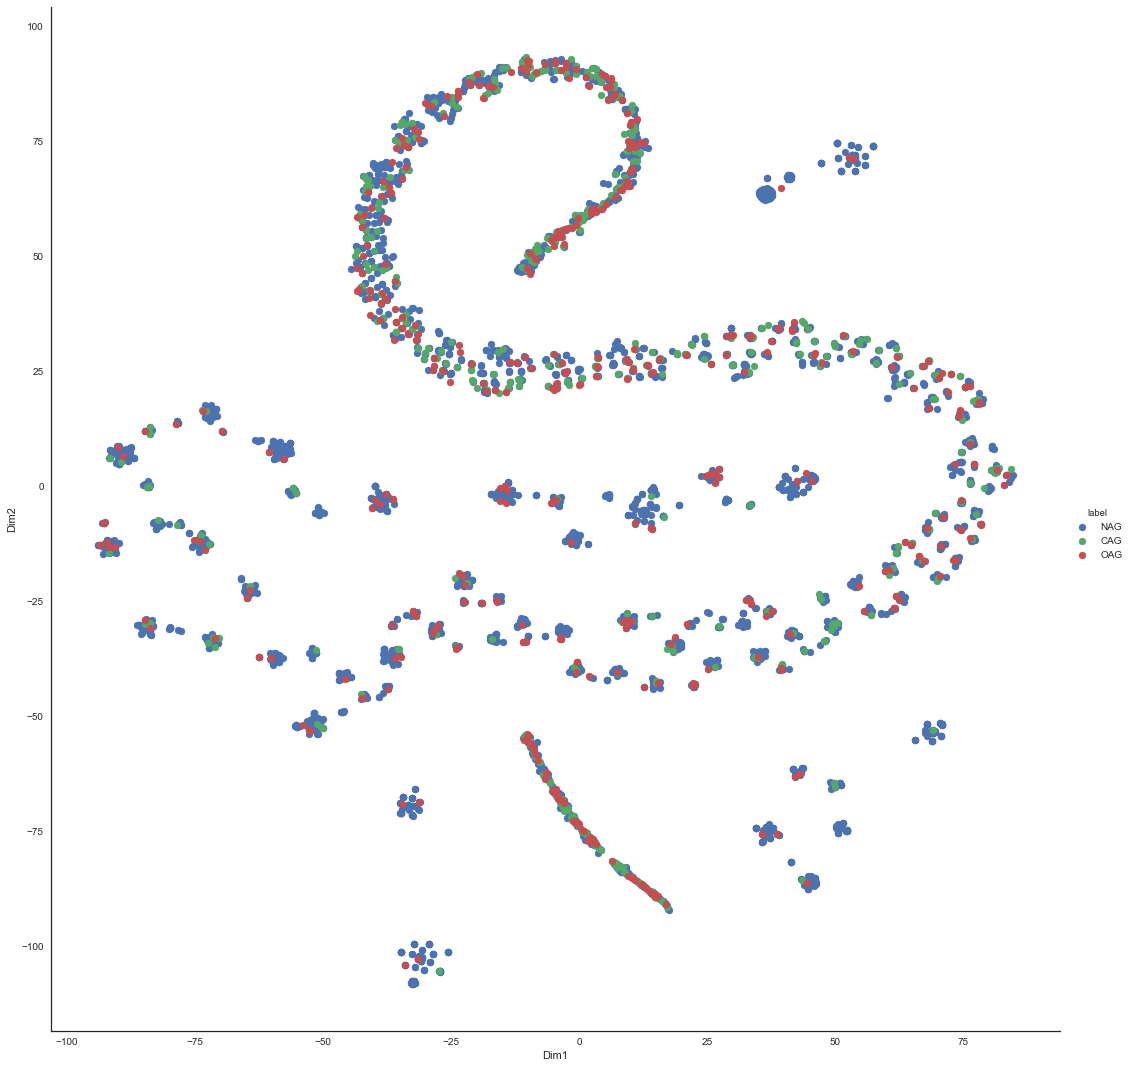

In [170]:
run_tsne(lda_df, y, lda_df.shape[1])

## Generating a Corpus for Skip-Gram Models

In [ ]:
def get_corpus(df):
    lines = [str(s).split() for s in df['monolingual']] # Creating a corpus / [list of [lists]]
    return lines

In [364]:
corpus = get_corpus(eng)
# corpus = get_corpus(hin)
# corpus = get_corpus(ben)

## Word2Vec

In [365]:
# phrases = Phrases(sentences=corpus,min_count=25,threshold=50)
# bigram = Phraser(phrases)

In [366]:
# for index,sentence in enumerate(corpus):
#     corpus[index] = bigram[sentence]

In [367]:
# shuffle corpus
def shuffle_corpus(sentences):
    shuffled = list(sentences)
    random.shuffle(shuffled)
    return shuffled

### Average Word2Vec 

In [368]:
# sg - skip gram |  window = size of the window | size = vector dimension
size = 100
window_size = 2 # sentences weren't too long, so
epochs = 100
min_count = 2
workers = 4

In [ ]:
def avg_w2v(corpus, window_size, size, min_count, workers, epochs, lang):
    # The Word2Vec Model using Gensim
    w2v = Word2Vec(corpus, sg=1, window=window_size, size=size, min_count=min_count, workers=workers, iter=epochs, sample=0.01)
    w2v.build_vocab(sentences=shuffle_corpus(corpus), update=True)
    for i in range(5):
        w2v.train(sentences=shuffle_corpus(corpus), epochs=50, total_examples=w2v.corpus_count)
    w2v.save('w2v.model')

    # Average Word2Vec
    sent_list = []
    k = 0
    for sent in lines:
        avg_w2v = np.empty(100)
        n = 0
        for j in range(len(sent)):
            try:
                avg_w2v += w2v[sent[j]]
                n += 1
            except KeyError:
                continue
        sentence = avg_w2v/(n+np.finfo(float).eps)
        sent_list.append(sentence.tolist())
    w2v_df = pd.DataFrame(sent_list)
    
    lang_dict = {'en': eng['Sub-task B'], 'hi': hin['Sub-task B'], 'bn': ben['Sub-task B']}
    w2v_df['Sub-task B'] = lang_dict[lang]
    
    fname = 'avg_w2v_'+lang
    w2v_df.to_csv(fname, index=False)
    
    return w2v_df

In [369]:
avg_w2v_df = avg_w2v(corpus, window_size, size, min_count, workers, epochs, lang='en')
# avg_w2v_df = avg_w2v(corpus, window_size, size, min_count, workers, epochs, lang='hi')
# avg_w2v_df = avg_w2v(corpus, window_size, size, min_count, workers, epochs, lang='bn')

In [371]:
# load word2vec model
# w2v = Word2Vec.load('w2v.model')
# w2v eval from https://www.kaggle.com/harmanpreet93/train-word2vec-on-hotel-reviews-dataset

t-SNE Completed. Total time it took: 83.18063187599182 seconds


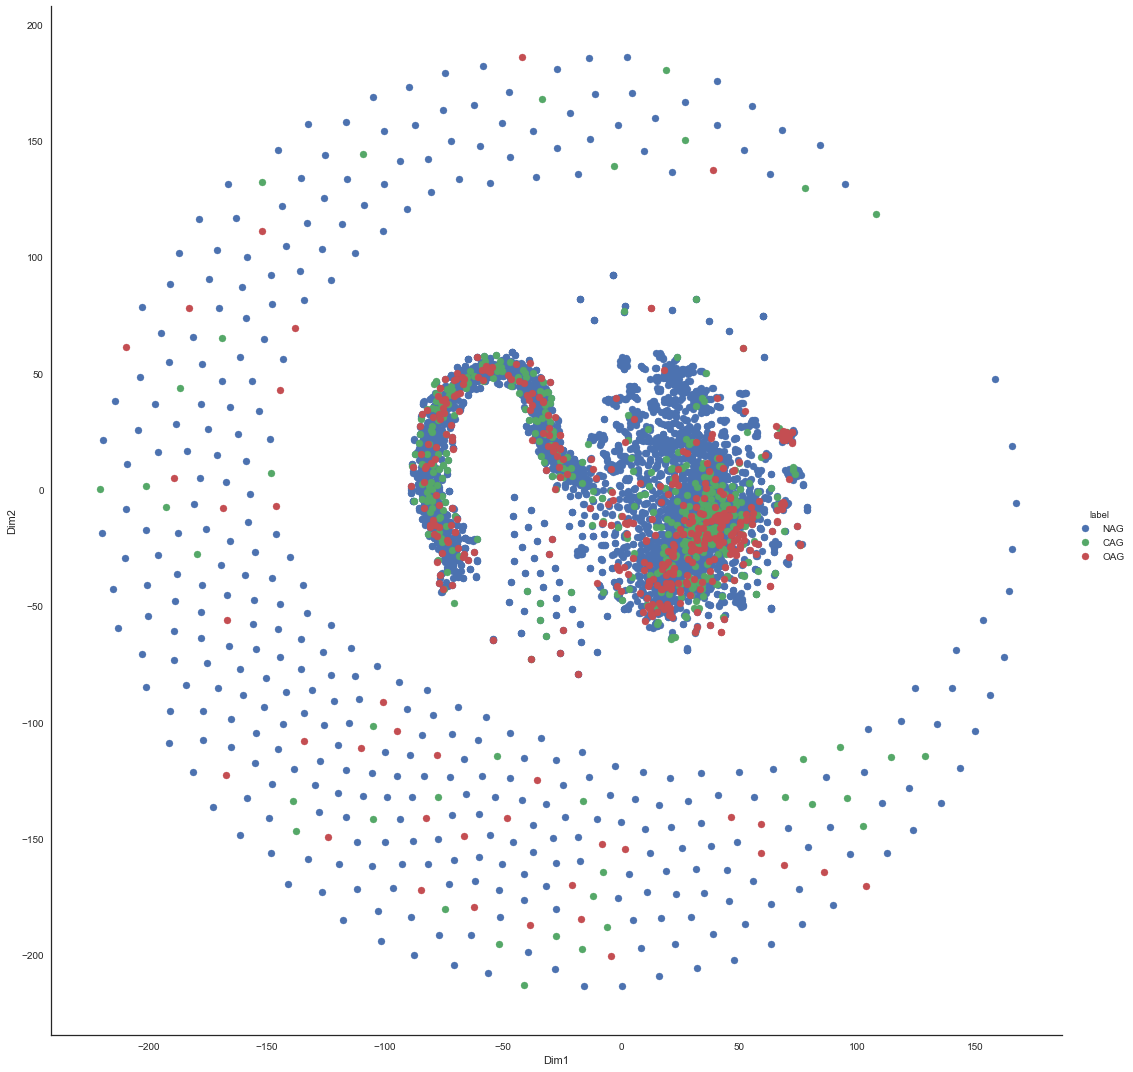

In [375]:
run_tsne(avg_w2v_df, y, avg_w2v_df.shape[1])

### TF-IDF Weighted Word2Vec

In [ ]:
def tfidf_w2v(corpus, window_size, size, min_count, workers, epochs):
    # The Word2Vec Model using Gensim
    w2v = Word2Vec(corpus, sg=1, window=window_size, size=size, min_count=min_count, workers=workers, iter=epochs, sample=0.01)
    w2v.build_vocab(sentences=shuffle_corpus(corpus), update=True)
    for i in range(5):
        w2v.train(sentences=shuffle_corpus(corpus), epochs=50, total_examples=w2v.corpus_count)
    w2v.save('w2v.model')
    
    # refer to scikit-learn, tfidf vectorizer documentation to tune min_df and max_df 
    tfidf_w2v = TfidfVectorizer(ngram_range=(1, 5), min_df=.01)
    w2v_words = w2v.wv.vocab

    # Weights Dict
    x = eng_train_clean['monolingual'].apply(lambda w : str(w))
    tfidf_w2vecs = tfidf_w2v.fit_transform(x)
    weights = dict(zip(tfidf_w2v.get_feature_names(), tfidf_w2v.idf_))
    
    tfidf_features = tfidf_w2v.get_feature_names()
    tfidf_sent_vectors = []
    row = 0
    for sent in tqdm(lines):
        sent_vec = np.zeros(100)
        weight_sum = 0
        for word in sent:
            if word in w2v_words and word in tfidf_features:
                vec = w2v.wv[word]
                tf_idf = weights[word]*(sent.count(word)/len(sent))
                sent_vec += (vec*tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec.tolist())
        row += 1
        
    tfidf_w2v_df = pd.DataFrame(tfidf_sent_vectors)
    
    lang_dict = {'en': eng['Sub-task B'], 'hi': hin['Sub-task B'], 'bn': ben['Sub-task B']}
    tfidf_w2v_df['Sub-task B'] = lang_dict[lang]
    
    fname = 'tfidf_w2v_'+lang
    tfidf_w2v_df.to_csv(fname, index=False)
    
    return tfidf_w2v_df

In [ ]:
tfidf_w2v_df = tfidf_w2v(corpus, window_size, size, min_count, workers, epochs, lang='en')
# tfidf_w2v_df = tfidf_w2v(corpus, window_size, size, min_count, workers, epochs, lang='hi')
# tfidf_w2v_df = tfidf_w2v(corpus, window_size, size, min_count, workers, epochs, lang='bn')

t-SNE Completed. Total time it took: 81.73381495475769 seconds


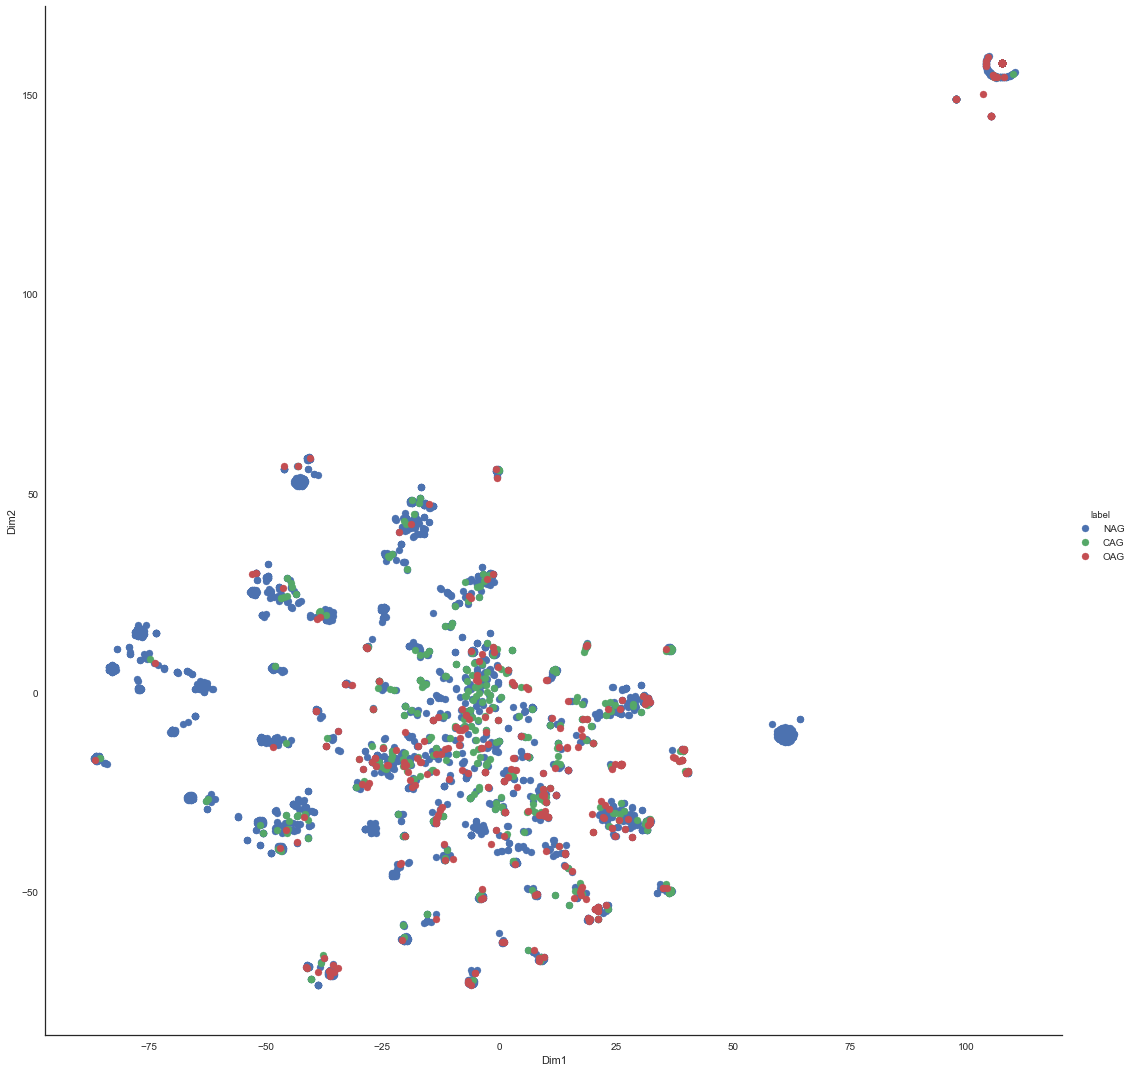

In [379]:
run_tsne(tfidf_w2v_df, y, tfidf_w2v_df.shape[1])

**The normal one looked better than the shuffled corpus tbh**

## GloVe Embeddings

### Corpus Trained GloVe

In [261]:
def generate_co_occurrence_matrix(corpus):
    vocab = set(corpus)
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
 
    # Create bigrams from all words in corpus
    bi_grams = list(bigrams(corpus))
 
    # Frequency distribution of bigrams ((word1, word2), num_occurrences)
    bigram_freq = nltk.FreqDist(bi_grams).most_common(len(bi_grams))
 
    # Initialise co-occurrence matrix
    # co_occurrence_matrix[current][previous]
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))
 
    # Loop through the bigrams taking the current and previous word,
    # and the number of occurrences of the bigram.
    for bigram in bigram_freq:
        current = bigram[0][1]
        previous = bigram[0][0]
        count = bigram[1]
        pos_current = vocab_index[current]
        pos_previous = vocab_index[previous]
        co_occurrence_matrix[pos_current][pos_previous] = count
    co_occurrence_matrix = np.matrix(co_occurrence_matrix)
 
    # return the matrix and the index
    return co_occurrence_matrix, vocab_index

In [388]:
def co_occurrence_df(corpus):
    # Create one list using many lists
    data = list(itertools.chain.from_iterable(corpus))
    matrix, vocab_index = generate_co_occurrence_matrix(data)
    data_matrix = pd.DataFrame(matrix, index=vocab_index, columns=vocab_index)
    return np.array(data_matrix)

,neglect,tag,class,bacterial,drama,krskte,doubt,rendering,craziness,four,...,tribal,film,word,discovered,view,raise,liking,bad,posting,chill
neglect,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
class,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bacterial,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
drama,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
krskte,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doubt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rendering,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
craziness,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
four,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [242]:
data_matrix = co_occurrence_df(corpus)
pd.DataFrame(data_matrix)

In [242]:
def glove_embeddings(corpus, lang):
    data_matrix = co_occurrence_df(corpus)
    glove = GloVe(n=300, max_iter=1000) 
    embeddings = glove.fit(data_matrix)
    embeddings = pd.DataFrame(embeddings)
    fname = 'glove_'+lang
    embeddings.to_csv(fname, index=False)
    return embeddings

Iteration 1000: error 0.0027

array([[-0.00307367, -0.029363  ,  0.0374286 , ...,  0.01461433,
        -0.03661498, -0.00838053],
       [-0.00060389, -0.02162649,  0.03546075, ..., -0.03162759,
        -0.0304772 ,  0.01673597],
       [-0.0237541 , -0.01043325, -0.01181269, ..., -0.0088648 ,
         0.01232723,  0.04435216],
       ...,
       [-0.05975632, -0.00463997, -0.02441853, ...,  0.05744439,
         0.00093427,  0.06000691],
       [-0.00209003,  0.01864768, -0.01472435, ...,  0.01589482,
         0.00718688, -0.00182206],
       [-0.00414972, -0.00519305, -0.01051859, ...,  0.00868516,
        -0.02128282,  0.02655739]])

In [ ]:
glove_df = glove_embeddings(corpus, lang='en')
# glove_df = glove_embeddings(corpus, lang='hi')
# glove_df = glove_embeddings(corpus, lang='bn')
glove_df.sample(5)